In [27]:
from nba_api.stats.endpoints import LeagueGameLog
import pandas as pd
import numpy as np
import os 
import glob
import matplotlib.pyplot as plt
import plotly.express as px

# Data Cleaning
data fetched from NBA API using methods in get_data.ipynb

In [2]:
season = '2023-24'
game_log = LeagueGameLog(season=season, season_type_all_star='Regular Season').get_data_frames()[0]

In [3]:
files = glob.glob(os.path.join('Data/',"*.csv"))
dataframes = {}

for file in files:
    file_name = os.path.basename(file)
    base_name = os.path.splitext(file_name)[0]

    df = pd.read_csv(file)

    dataframes[base_name] = df

advanced_box23 = dataframes['2023-24_advanced_box_data']
play_by_play23 = dataframes['2023-24_play_by_play']
play_tracking23 = dataframes['2023-24_playertracking_data']
shot_chart23 = dataframes['2023-24_shotchart_data']

play_type23 = dataframes['2023-24_play_type']


# Merge in stages
box = advanced_box23.merge(play_tracking23, on='personId', how='outer')
#merged_df2 = merged_df1.merge(play_tracking23, on='personId', how='outer')
#game_stats_2324 = merged_df2.merge(shot_chart23, on='personId', how='outer')




In [58]:
# Create key columns
advanced_box23['combined_key'] = advanced_box23['gameId'].astype(str) + '_' + advanced_box23['personId'].astype(str)
play_tracking23['combined_key'] = play_tracking23['gameId'].astype(str) + '_' + play_tracking23['personId'].astype(str)

#merge on key drop duplcated columns 
#https://stackoverflow.com/questions/19125091/pandas-merge-how-to-avoid-duplicating-columns
box23_24 = advanced_box23.merge(play_tracking23, on='combined_key', how='outer', suffixes=('', '_y'))
box23_24.drop(box23_24.filter(regex='_y$').columns, axis=1, inplace=True)
box23_24.drop(columns=['combined_key'])


,gameId,teamId,teamCity,teamName,teamTricode,teamSlug,personId,firstName,familyName,nameI,...,contestedFieldGoalsMade,contestedFieldGoalsAttempted,contestedFieldGoalPercentage,uncontestedFieldGoalsMade,uncontestedFieldGoalsAttempted,uncontestedFieldGoalsPercentage,fieldGoalPercentage,defendedAtRimFieldGoalsMade,defendedAtRimFieldGoalsAttempted,defendedAtRimFieldGoalPercentage
0,22300001,1610612754,Indiana,Pacers,IND,pacers,1626167,Myles,Turner,M. Turner,...,2,5,0.400,7,9,0.778,0.643,3,6,0.50
1,22300001,1610612754,Indiana,Pacers,IND,pacers,1627741,Buddy,Hield,B. Hield,...,1,2,0.500,4,7,0.571,0.556,3,6,0.50
2,22300001,1610612739,Cleveland,Cavaliers,CLE,cavaliers,1627745,Damian,Jones,D. Jones,...,0,0,0.000,0,0,0.000,0.000,0,0,0.00
3,22300001,1610612739,Cleveland,Cavaliers,CLE,cavaliers,1627747,Caris,LeVert,C. LeVert,...,4,7,0.571,1,4,0.250,0.416,3,4,0.75
4,22300001,1610612739,Cleveland,Cavaliers,CLE,cavaliers,1627777,Georges,Niang,G. Niang,...,1,2,0.500,3,7,0.429,0.444,2,2,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32380,22301230,1610612740,New Orleans,Pelicans,NOP,pelicans,202685,Jonas,Valanciunas,J. Valanciunas,...,0,0,0.000,0,0,0.000,0.333,0,0,0.00
32381,22301230,1610612747,Los Angeles,Lakers,LAL,lakers,203076,Anthony,Davis,A. Davis,...,0,0,0.000,0,0,0.000,0.500,0,0,0.00
32382,22301230,1610612740,New Orleans,Pelicans,NOP,pelicans,203468,CJ,McCollum,C. McCollum,...,0,0,0.000,0,0,0.000,0.285,0,0,0.00
32383,22301230,1610612740,New Orleans,Pelicans,NOP,pelicans,203469,Cody,Zeller,C. Zeller,...,0,0,0.000,0,0,0.000,0.000,0,0,0.00


In [53]:
box23_24.columns

Index(['gameId', 'teamId', 'teamCity', 'teamName', 'teamTricode', 'teamSlug',
       'personId', 'firstName', 'familyName', 'nameI', 'playerSlug',
       'position', 'comment', 'jerseyNum', 'minutes',
       'estimatedOffensiveRating', 'offensiveRating',
       'estimatedDefensiveRating', 'defensiveRating', 'estimatedNetRating',
       'netRating', 'assistPercentage', 'assistToTurnover', 'assistRatio',
       'offensiveReboundPercentage', 'defensiveReboundPercentage',
       'reboundPercentage', 'turnoverRatio', 'effectiveFieldGoalPercentage',
       'trueShootingPercentage', 'usagePercentage', 'estimatedUsagePercentage',
       'estimatedPace', 'pace', 'pacePer40', 'possessions', 'PIE', 'GAME_ID',
       'combined_key', 'speed', 'distance', 'reboundChancesOffensive',
       'reboundChancesDefensive', 'reboundChancesTotal', 'touches',
       'secondaryAssists', 'freeThrowAssists', 'passes', 'assists',
       'contestedFieldGoalsMade', 'contestedFieldGoalsAttempted',
       'contestedFi

In [59]:
#box23_24.isnull().sum()
#na values
    #position: non starters have no position data, Drop will make our own
    #comment: only rows with values are for did not play coaches dcision or Injury, and na 
    #jerseyNum: not a single value, Drop no value
    #minutes: inverse of comment collumn, fill zeros

box23_24 = box23_24.drop(columns=['jerseyNum','position'])
box23_24.fillna({'comment' : 'none'},inplace=True)
box23_24.fillna({'minutes' : 0},inplace=True)

# EDA

In [7]:
#change player slug formating to use as name in player_box dictinary of player box scores
box23_24['playerSlug'] = box23_24['playerSlug'].str.replace('-', '_', regex=False)

player_box = {}

for player in box23_24['personId']:
    player_df = box23_24[box23_24['personId']== player]
    playerslug = player_df['playerSlug'].values[0]

    player_box[playerslug] = player_df
    

In [14]:
player_df

,gameId,teamId,teamCity,teamName,teamTricode,teamSlug,personId,firstName,familyName,nameI,...,contestedFieldGoalsMade,contestedFieldGoalsAttempted,contestedFieldGoalPercentage,uncontestedFieldGoalsMade,uncontestedFieldGoalsAttempted,uncontestedFieldGoalsPercentage,fieldGoalPercentage,defendedAtRimFieldGoalsMade,defendedAtRimFieldGoalsAttempted,defendedAtRimFieldGoalPercentage
399,22300015,1610612747,Los Angeles,Lakers,LAL,lakers,2544,LeBron,James,L. James,...,6,6,1.000,5,11,0.455,0.647,3,4,0.75
683,22300026,1610612747,Los Angeles,Lakers,LAL,lakers,2544,LeBron,James,L. James,...,0,1,0.000,6,10,0.600,0.545,0,1,0.00
950,22300036,1610612747,Los Angeles,Lakers,LAL,lakers,2544,LeBron,James,L. James,...,3,4,0.750,10,18,0.556,0.590,1,2,0.50
1107,22300042,1610612747,Los Angeles,Lakers,LAL,lakers,2544,LeBron,James,L. James,...,0,1,0.000,6,9,0.667,0.599,5,5,1.00
1617,22300061,1610612747,Los Angeles,Lakers,LAL,lakers,2544,LeBron,James,L. James,...,5,8,0.625,5,8,0.625,0.625,5,5,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30385,22301155,1610612747,Los Angeles,Lakers,LAL,lakers,2544,LeBron,James,L. James,...,8,13,0.615,6,9,0.667,0.636,1,1,1.00
30977,22301177,1610612747,Los Angeles,Lakers,LAL,lakers,2544,LeBron,James,L. James,...,4,7,0.571,9,13,0.692,0.650,2,2,1.00
31469,22301195,1610612747,Los Angeles,Lakers,LAL,lakers,2544,LeBron,James,L. James,...,5,7,0.714,6,13,0.462,0.550,1,1,1.00
31681,22301203,1610612747,Los Angeles,Lakers,LAL,lakers,2544,LeBron,James,L. James,...,7,14,0.500,5,11,0.455,0.479,3,3,1.00


/tmp/ipykernel_165629/3827260718.py:14: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



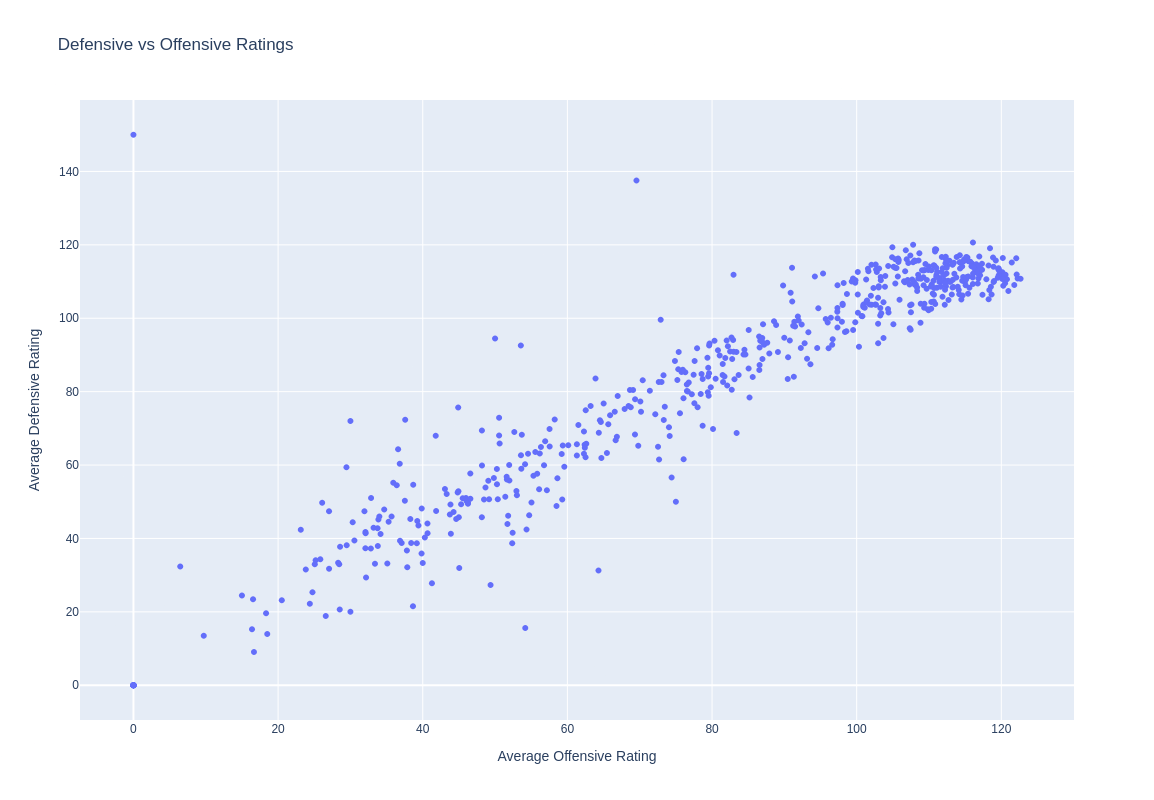

In [42]:
# Create an empty DataFrame for the results
ratings_df = pd.DataFrame(columns=['Player', 'Average_Off_Rating', 'Average_Def_Rating'])

# Calculate average ratings for each player and append to the DataFrame
for player, df in player_box.items():
    avg_off_rating = df['offensiveRating'].mean()
    avg_def_rating = df['defensiveRating'].mean()
    player_df = pd.DataFrame({
        'Player': [player],
        'Average_Off_Rating': [avg_off_rating],
        'Average_Def_Rating': [avg_def_rating]
    })
    # Append the player's DataFrame to the main DataFrame
    ratings_df = pd.concat([ratings_df, player_df], ignore_index=True)


# Create an interactive scatter plot
fig = px.scatter(
    ratings_df,
    x='Average_Off_Rating',
    y='Average_Def_Rating',
    title='Defensive vs Offensive Ratings of Each Player',
    labels={'Average_Off_Rating': 'Average Offensive Rating', 'Average_Def_Rating': 'Average Defensive Rating'}
)

# Update traces to customize hover labels GPT
fig.update_traces(
    hovertemplate='<b>%{text}</b><br>Offensive Rating: %{x}<br>Defensive Rating: %{y}<extra></extra>',
    text=ratings_df['Player'],
    mode='markers'  
)

# Ulayout 
fig.update_layout(
    xaxis_title='Average Offensive Rating',
    yaxis_title='Average Defensive Rating',
    title='Defensive vs Offensive Ratings',
    hovermode='closest',
    width=800, 
    height = 800
)

# Show the plot
fig.show()

In [45]:
asdf = box23_24.isnull()

In [46]:
asdf

,gameId,teamId,teamCity,teamName,teamTricode,teamSlug,personId,firstName,familyName,nameI,...,contestedFieldGoalsMade,contestedFieldGoalsAttempted,contestedFieldGoalPercentage,uncontestedFieldGoalsMade,uncontestedFieldGoalsAttempted,uncontestedFieldGoalsPercentage,fieldGoalPercentage,defendedAtRimFieldGoalsMade,defendedAtRimFieldGoalsAttempted,defendedAtRimFieldGoalPercentage
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32380,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
32381,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
32382,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
32383,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [50]:
box23_24.isnull().sum()
#na values
    #position: non starters have no position data 
    #comment: only rows with values are for did not play coaches dcision or Injury
    #jerseyNum: not a single value 
    #minuents: inverse of comment collumn 

gameId                                  0
teamId                                  0
teamCity                                0
teamName                                0
teamTricode                             0
teamSlug                                0
personId                                0
firstName                               0
familyName                              0
nameI                                   0
playerSlug                              0
position                            20085
comment                             26401
jerseyNum                           32385
minutes                              5984
estimatedOffensiveRating                0
offensiveRating                         0
estimatedDefensiveRating                0
defensiveRating                         0
estimatedNetRating                      0
netRating                               0
assistPercentage                        0
assistToTurnover                        0
assistRatio                       